# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [7]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [9]:
# your code here
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')
print(bikes_df_raw.info())
bikes_df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
dteday        17379 non-null object
season        17379 non-null int64
hour          17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.7+ MB
None


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [10]:
# your code here
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [11]:
# your code here
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

*Your answer here*

The temperature(`temp`), average temperature (`atemp`)	humidity (`hum`), and windspeed (`winspeed`) variables seem to have been normalized to range from 0 to 1. If not, for instance, DC would see high of 1 degrees and a low of 0.2 degrees farenheight.

All data types make sense for the data stored, except dteday, which is an object.


**1.2 Notice that the variable in column...**

In [12]:
# your code here
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'])
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

**1.3 Create three new columns in the dataframe:...**

In [13]:
# your code here

# function to assign 0 to 2011 and 1 to 2012
def encode_year(x):
    return np.int64(np.floor(x-2011))
   
    
# create `year` column
bikes_df_raw.loc[:,'year'] = bikes_df_raw.dteday.dt.year

# create `month` column
bikes_df_raw.loc[:,'month'] = bikes_df_raw.dteday.dt.month
   
# encode `year` column with 0 and 1
bikes_df_raw['year'] = bikes_df_raw['year'].apply(encode_year)

bikes_df_raw['counts'] = bikes_df_raw.casual + bikes_df_raw.registered

# re-organize the columns 
columns = ['dteday','hour','season', 'holiday', 'year','month','weekday',
           'workingday','weather', 'temp', 'atemp', 'hum', 'windspeed',
           'casual', 'registered', 'counts']
bikes_df_raw = bikes_df_raw.reindex(columns = columns)

bikes_df_raw.head()

,dteday,hour,season,holiday,year,month,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts
0,2011-01-01,0,1,0,0,1,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,2,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,3,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,4,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [14]:
# your code here

bikes_by_day = bikes_df_raw.copy()

# for scatterplot of season against counts first we need to group by day and 
# aggregate counts
bikes_by_day = bikes_by_day[['dteday', 'weather', 
                             'season', 'windspeed', 'temp', 'atemp', 
                             'hum', 
                             'weekday', 'casual', 'registered', 
                             'counts']].groupby('dteday').agg({'counts' : np.sum,
                                                                'casual' : np.sum,
                                                                'weather': np.max,
                                                                'registered' : np.sum,
                                                                'season' : np.mean,
                                                                'weekday' : np.mean,
                                                                'windspeed': np.mean,
                                                                'temp' : np.mean,
                                                                'atemp' : np.mean,
                                                                'hum' : np.mean})
bikes_by_day.head(5)

,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
dteday,,,,,,,,,,
2011-01-01,985,331,3,654,1,6,0.160446,0.344167,0.363625,0.805833
2011-01-02,801,131,3,670,1,0,0.248539,0.363478,0.353739,0.696087
2011-01-03,1349,120,1,1229,1,1,0.248309,0.196364,0.189405,0.437273
2011-01-04,1562,108,2,1454,1,2,0.160296,0.200000,0.212122,0.590435
2011-01-05,1600,82,1,1518,1,3,0.186900,0.226957,0.229270,0.436957


In [15]:
# your code here
reg_color = 'blue'
casual_color = 'orange'

days_tick_dict = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
                 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}  

hours_tick_dict = {k:v for k,v in zip(range(24),range(24))}
def get_violin_lists(bikes_data, colname):
    """Helper function for building violin plots."""
    
    # prepare the lists
    reg_data = []
    cas_data = []
    
    # at each day, record ALL values of 'rigistered' and 'casual' observed    
    for cur_val, cur_df in bikes_data.groupby(colname):
        cur_registered = cur_df['registered'].copy().values.reshape(-1,1)
        cur_casual = cur_df['casual'].copy().values.reshape(-1,1)

        reg_data.append(cur_registered)
        cas_data.append(cur_casual)
    
    # return the lists
    return reg_data,cas_data


# color the registered users orange
def color_violin(violin_result, color_string):
    """Helper to color a violin plot"""
  
    # color the distribution
    for pc in violin_result['bodies']:
        pc.set_color(color_string)

    # color the lines
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_result[partname]
        vp.set_edgecolor(color_string)
        

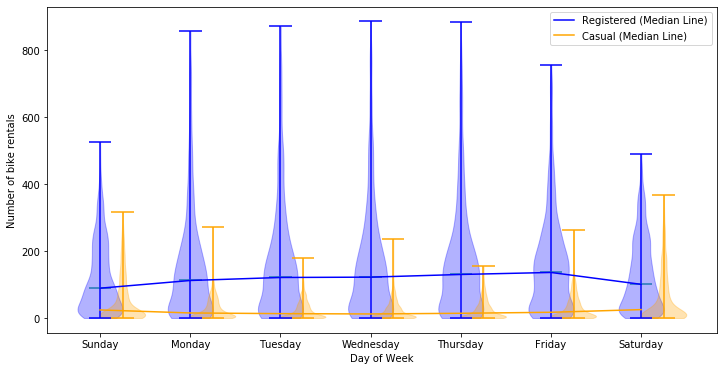

In [16]:
# your code here

# get data for the violin plot
reg_data,cas_data = get_violin_lists(bikes_df_raw, 'weekday')

# plot the violins
plt.figure(figsize=(12,6))
plt.xticks(list(days_tick_dict.keys()), list(days_tick_dict.values()))
position_array = np.arange(len(reg_data))
reg = plt.violinplot(dataset=reg_data, positions=position_array, showmedians=True, showextrema=True)
cas = plt.violinplot(dataset=cas_data, positions=position_array+.25)

# color the violins
color_violin(reg, reg_color)
color_violin(cas, casual_color)

# calculate the median number of registered/casual riders on each weekday
mids = bikes_df_raw.groupby("weekday").median()[["registered","casual"]]

# plot a line connecting the medians of each ditribution
med = plt.plot(position_array, mids["registered"].values,c = reg_color, label="Registered (Median Line)")
medb = plt.plot(position_array, mids["casual"].values,c=casual_color, label="Casual (Median Line)")

# labels
plt.ylabel('Number of bike rentals')
plt.xlabel('Day of Week')
plt.legend()

plt.show()

**2.2 Use `bikes_by_day` to visualize how the distribution...**

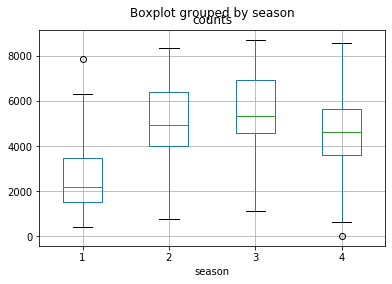

In [11]:
bikes_by_day.boxplot('counts',by='season');

In [12]:
# your code here

# find outlier of variable var_of_interest for season s
def find_outlier(s, var_of_interest, data):
    season_df = data[data.season == s]
    
    raw_data = season_df.loc[:,var_of_interest]
    q1 = np.percentile(raw_data,25)
    q3 = np.percentile(raw_data,75)
    IQR = q3 - q1
    
    upper_bound = q3 + 1.5*IQR 
    lower_bound = q1 - 1.5*IQR 
    
    outliers_flag = np.logical_or(raw_data>upper_bound, raw_data<lower_bound)
    
    if np.sum(outliers_flag) == 0:
        print ('no outliers found')
        return None
    else:
        print(np.sum(outliers_flag),"outlier(s) found")
        return season_df.loc[outliers_flag]
    

In [13]:
# your code here 
df = pd.DataFrame(columns = bikes_by_day.columns)

# find outliers in each season
for cur_season in [1,2,3,4]:
    print("Season {}".format(cur_season))
    df = df.append(find_outlier(cur_season, 'counts', bikes_by_day))

df

Season 1
1 outlier(s) found
Season 2
no outliers found
Season 3
no outliers found
Season 4
1 outlier(s) found


,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833
2012-10-29,22,2,3,20,4,1,0.358200,0.440000,0.439400,0.880000


**2012-03-17:** This is **St. Patricks Day** in 2012, which also happened to fall on a Saturday. It makes perfect sense that this date would represent an outlier among all recorded winter dates. The increased number of people renting bikes this day were likely out celebrating the holiday, perhaps choosing to bike rather than drive if drinking. And, because the holiday fell on a Saturday, celebrations likely persisted throughout the day, additionally contributing to the large number of rentals, during a season that typically sees far fewer relative rentals each day.

**2012-10-29:** This date coincides with the date when **Hurricane Sandy** would have been causing sever weather conditions in Washington D.C. (coinciding with its storm surge also hitting NYC). NOAA credits this as "the largest Atlantic hurricane on record, as well as the second-costliest Atlantic hurricane in history, only surpassed by Hurricane Katrina in 2005" \[Source 1\]. Additionally, D.C. Metro area, federal offices were closed this day, widespread power outages were experienced, and bus, rail, and subway service was cancelled \[Source 2\]. In fact, it was probably largely due to the cancelling of public transit service, that there were the 22 observed bike rentals that day, considering that people would have had few options for transportation if absolutely required.

sources:
1. National Weather Service. "October 29, 2012 Hurricane Sandy" https://www.weather.gov/mhx/Oct292012EventReview
2. Wikipedia. "Effects of Hurricane Sandy in Maryland and Washington, D.C." https://en.wikipedia.org/wiki/Effects_of_Hurricane_Sandy_in_Maryland_and_Washington,_D.C.

**2.3 Convert the categorical attributes...**

In [14]:
# your code here
categorical_columns = ['season', 'month', 'holiday', 'weekday', 'workingday', 'weather']
categorical_columns_g2cols = ['season', 'month', 'weekday', 'weather']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts']

bikes_df = pd.get_dummies(bikes_df_raw, columns=categorical_columns_g2cols, drop_first=True)

bikes_df.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
# your code here
bikes_df.columns

Index(['dteday', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'counts', 'season_2',
       'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [16]:
# your code here
# give more meaningful names to the one-hot encoded variables
seasons = {'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall',}
months = {'month_2': 'Feb', 'month_3': 'Mar', 'month_4': 'Apr',
          'month_5':'May', 'month_6': 'Jun', 'month_7': 'Jul', 
          'month_8': 'Aug', 'month_9': 'Sept', 'month_10': 'Oct',
          'month_11': 'Nov', 'month_12': 'Dec', }
weekdays = {'weekday_1': 'Mon', 'weekday_2': 'Tue', 'weekday_3': 'Wed',
            'weekday_4': 'Thu', 'weekday_5': 'Fri', 'weekday_6': 'Sat'}
weather = {'weather_2': 'Cloudy', 'weather_3': 'Snow', 'weather_4': 'Storm'}

combined_renamer = {**seasons, **months, **weekdays, **weather}

In [17]:
# your code here
bikes_df = bikes_df.rename(columns=combined_renamer)
bikes_df.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

As per Rashmi Banthia on the HW3 Errate posted on Ed:

> Question 2.4: Please ignore the statement - "Remember to specify the data's index column as you read it in."   

In [18]:
# your code here
### split in train and test, keeping equal representation of each on month in train and test
bikes_train, bikes_test = train_test_split(bikes_df, test_size=.5, 
                                           stratify=bikes_df_raw['month'], 
                                           random_state=90)

In [19]:
bikes_train.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
17280,2012-12-27,21,0,1,1,0.24,0.2273,0.60,0.2537,12,...,1,0,0,0,1,0,0,1,0,0
6747,2011-10-13,17,0,0,1,0.62,0.5758,0.83,0.2537,47,...,0,0,0,0,1,0,0,0,1,0
13948,2012-08-09,9,0,1,1,0.76,0.7273,0.66,0.1642,54,...,0,0,0,0,1,0,0,0,0,0
11005,2012-04-08,17,0,1,0,0.62,0.6061,0.22,0.2985,185,...,0,0,0,0,0,0,0,0,0,0
9322,2012-01-29,8,0,1,0,0.18,0.1970,0.40,0.1343,9,...,0,0,0,0,0,0,0,0,0,0


In [20]:
bikes_test.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
17336,2012-12-30,5,0,1,0,0.26,0.2273,0.48,0.2985,0,...,1,0,0,0,0,0,0,1,0,0
11486,2012-04-28,19,0,1,0,0.36,0.3485,0.71,0.1343,29,...,0,0,0,0,0,0,1,0,1,0
16889,2012-12-11,12,0,1,1,0.36,0.3182,0.53,0.4478,13,...,1,0,1,0,0,0,0,1,0,0
9601,2012-02-10,0,0,1,1,0.28,0.3030,0.65,0.0896,4,...,0,0,0,0,0,1,0,1,0,0
13508,2012-07-22,1,0,1,0,0.60,0.5455,0.88,0.1642,31,...,0,0,0,0,0,0,0,1,0,0


In [21]:
## Save test/training files
#bikes_train.to_csv('data/BSS_train.csv', index=False)
#bikes_test.to_csv('data/BSS_test.csv', index=False)

**2.5 Although we asked you to create your train and test set...**

In [22]:
# your code here
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_train = BSS_train.drop(['dteday'], axis=1)

BSS_test = pd.read_csv('data/BSS_test.csv')
BSS_test = BSS_test.drop(['dteday'], axis=1)

**2.6 Use pandas' `scatter_matrix` command to visualize...**

In [23]:
cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


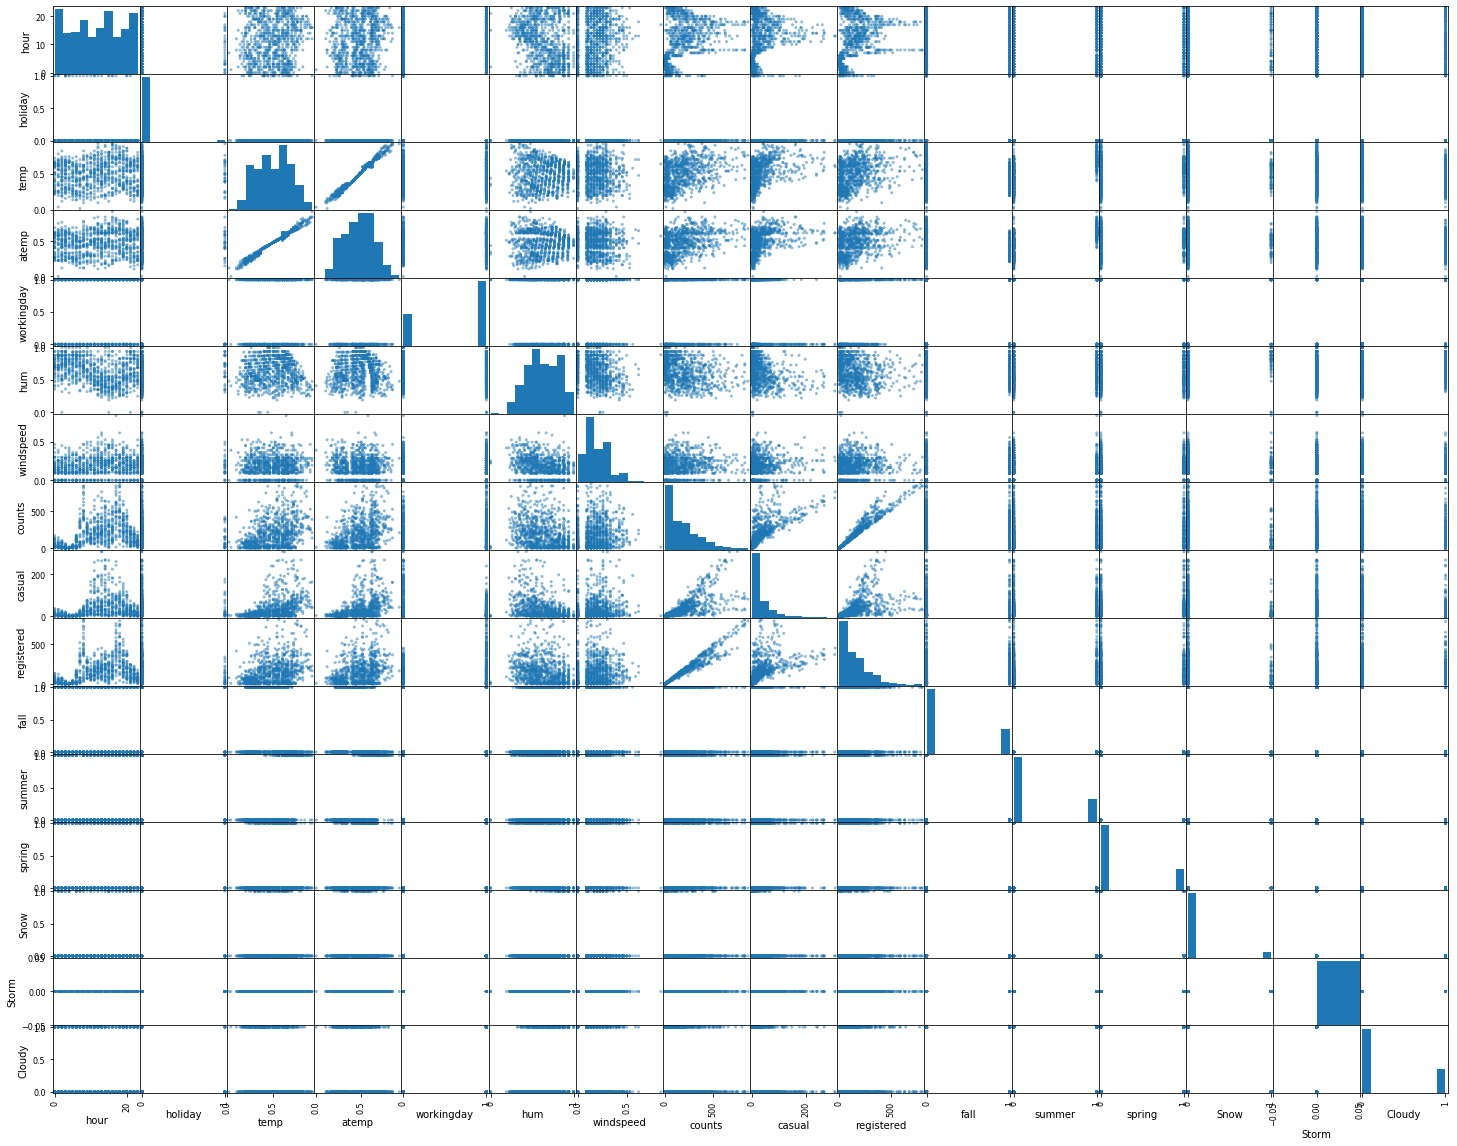

In [24]:
# your code here
scatter_matrix(BSS_train[cor_columns].sample(frac=0.1, axis=0), 
               alpha=0.5, figsize=(25,20));

The **most strongly correlated** variables appear to be `temp` and `atemp`, which makes perfect sense that the apparent temperature, while it might vary slightly from the temperature, any changes to one will still be very closely matched by changes in the other. The **next most strongly correlated** is `counts` with the `casual` and `registered` variables. This too makes sense because we created the `counts` variable as a sum of the other two variables. And, `registered` and `casual` themselves appear to be related to one another, with increases in one also exhibiting increases in the other, which makes sense that they types of days in which you see in increase in registered user rentals, you'd also likely see increases in casual user rentals as well.

Other notable relationships include the wholly expected **sinusoidal relationship** between `hour` of day with `temp` and `atemp` as well as `hum`, and the **multi-modal relationships** between `hour` with each of the rental count variables `registered`, `casual`, and `counts`.

The rental count variables also appear to have a **generally positive relationship** to `temp` and `atemp`, and a **generally negative relationship** to `hum`.

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

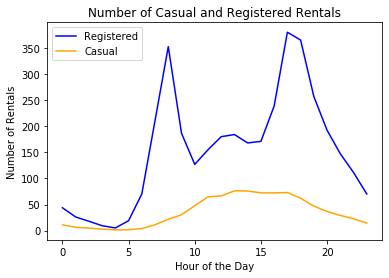

In [25]:
# your code here
mean_data = BSS_train.groupby('hour').aggregate({'casual': np.mean, 
                                                'registered': np.mean})

num_days = mean_data.shape[0]
plt.plot(np.arange(num_days), mean_data['registered'], 
         color = reg_color, label="Registered")
plt.plot(np.arange(num_days), mean_data['casual'], 
         color = casual_color, label="Casual")

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rentals")
plt.title("Number of Casual and Registered Rentals")
plt.legend();

As exhibited in the plot above, registered user rental trends by hour of day appear to be strongly multi-modal with peak average rentals occuring during the 8 a.m. and 5 to 6 p.m. hours. This is most likely the result of registered users more likely using this bike rental service for commuting to and from work. I would also suspect that, because a rider might use the rental bike service to commute, this would make paying registered user subsciption costs more cost effective, given the twice daily use of the bike and and savings they might experience by neither driving nor taking public transit. 

Casual users on the other hand, appear to account for far fewer hourly rentals in general, and the pattern of their use appears to rise in the morning hours and stay relatively constant from the hours of 11 a.m. until 5 p.m., before decreasing again into the late evening and nighttime.

**2.8 Use the weather related variables to show how each weather...** 

In [26]:
weather_msk = {'Cloudy': BSS_train.Cloudy == 1,
               'Snow': BSS_train.Snow == 1, 
               'Storm': BSS_train.Storm == 1,
               'Clear': (BSS_train.Cloudy == 0) & (BSS_train.Snow == 0) & (BSS_train.Storm == 0)}

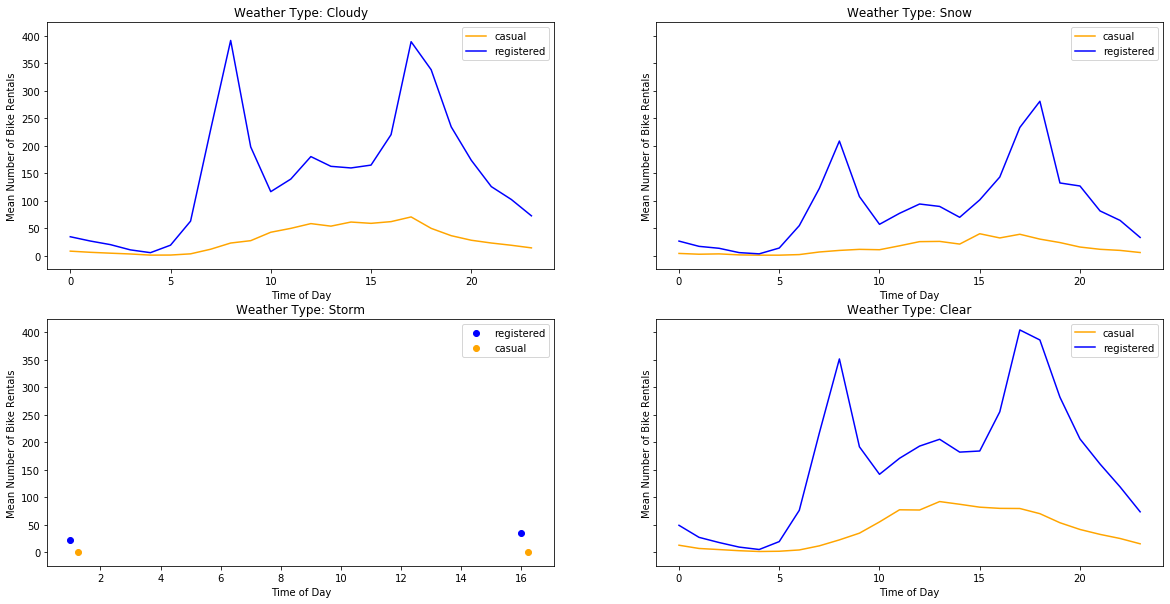

In [27]:
fig, ax = plt.subplots(2,2, figsize=(20,10), sharey=True)
ax = ax.ravel()

for i, key in enumerate(weather_msk):    
    bikes_df_weather = BSS_train[weather_msk[key]]
    
    #for most weathers, we just plot the mean at each hour
    mean_data = bikes_df_weather.groupby('hour').aggregate({'casual': np.mean, 
                                                            'registered': np.mean})

    # mean lines
    reg_hourly_data_mean = mean_data['registered']
    cas_hourly_data_mean = mean_data['casual']

    if key == 'Storm':
        # for blizard weather we have maximum one data point per hour, 
        # and often none just scatter plot the data
        reg = ax[i].scatter(bikes_df_weather['hour'].values, 
                            bikes_df_weather['registered'].values, 
                            color = reg_color, label="registered")
        
        cas = ax[i].scatter(bikes_df_weather['hour'].values+.25, 
                            bikes_df_weather['casual'].values, 
                            color = casual_color, label="casual")
    else:
        ax[i].plot(cas_hourly_data_mean, casual_color, label="casual")
        ax[i].plot(reg_hourly_data_mean, reg_color, label="registered")
    
    ax[i].legend()
    
    ax[i].set_ylabel('Mean Number of Bike Rentals')
    ax[i].set_xlabel('Time of Day')
    ax[i].set_title('Weather Type: {}'.format(key))

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,10), sharey=True)
ax = ax.ravel()

for i, key in enumerate(weather_msk):    
    bikes_df_weather = BSS_train[weather_msk[key]]
    
    #for most weathers, we just plot the mean at each hour
    mean_data = bikes_df_weather.groupby('hour').aggregate({'casual': np.mean, 
                                                            'registered': np.mean})

    # mean lines
    reg_hourly_data_mean = mean_data['registered']
    cas_hourly_data_mean = mean_data['casual']

    if key == 'Storm':
        # for blizard weather we have maximum one data point per hour, 
        # and often none just scatter plot the data
        reg = ax[i].scatter(bikes_df_weather['hour'].values, 
                            bikes_df_weather['registered'].values, 
                            color = reg_color, label="registered")
        
        cas = ax[i].scatter(bikes_df_weather['hour'].values+.25, 
                            bikes_df_weather['casual'].values, 
                            color = casual_color, label="casual")
    else:
        ax[i].plot(cas_hourly_data_mean, casual_color, label="casual")
        ax[i].plot(reg_hourly_data_mean, reg_color, label="registered")
    
    ax[i].legend()
    
    ax[i].set_ylabel('Mean Number of Bike Rentals')
    ax[i].set_xlabel('Time of Day')
    ax[i].set_title('Weather Type: {}'.format(key))
    

As shown in the figures above, average hourly rentals by registered and casual users exhibit very similar hour-to-hour trends for days in which weather was labeled "clear", "cloudy", or "snow." For each of these weather types registered user averages were still multi-modal and peaked during the morning and evening commute hours and casual user averages grew during the day and decreased into the evening and nighttime. However, during days labeled "snow", the averages were notably lower at all hours during the daytime hours for both user groups meaning fewer riders rented bikes on those days.

The days labeled "storm" appear to have only had two observations, providing very little indication of what trends might be exhibited if there had been more of these days.

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [28]:
trivial_cols = ['casual','registered']

BSS_train = BSS_train.drop(trivial_cols, axis=1)
BSS_test = BSS_test.drop(trivial_cols, axis=1)

In [29]:
# your code here

# multiple linear regression
X_train = sm.add_constant(BSS_train.drop('counts', axis=1))
X_test = sm.add_constant(BSS_test.drop('counts', axis=1))

y_train = BSS_train['counts'].values.reshape(-1,1)
y_test = BSS_test['counts'].values.reshape(-1,1)

model = OLS(y_train, X_train)
results = model.fit()

results.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        10:59:51   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

In [30]:
# your code here
y_hat_train = results.predict()
y_hat_test = results.predict(exog=X_test)

# calculating and reporting the requested values, particularly the Test R^2
print('Train R^2 = {:.4}'.format(results.rsquared))
print('Test R^2 = {:.4}'.format(r2_score(bikes_test['counts'], y_hat_test)))

Train R^2 = 0.4116
Test R^2 = 0.4007


**3.2 Examine the estimated coefficients and report...**

In [31]:
# your code here
results.params[((results.pvalues < 0.005) & (results.params > 0))]

hour            7.209247
year           78.121108
workingday     10.948441
temp          273.662515
spring         50.075412
fall           70.947417
dtype: float64

In [32]:
# your code here
results.params[((results.pvalues < 0.005) & (results.params < 0))]

hum    -202.008009
Apr     -44.832594
May     -50.160547
Jun     -72.204151
Jul     -90.896453
Aug     -58.324552
Snow    -26.815450
dtype: float64

**3.3 You should see some strange estimates for the predictors representing months...** 

**INTERPRETATION:**

July is exihibiting the most negative estimated coefficient (-90.9) of all months, which means all other predictors remaining the same, the model will predict 90.9 fewer bike rentals for the month of July. A few things could be contributing to the negative relationship between this predictor and the variable of interest. First of all, from the plot above, we can see that coefficients for months become increasingly negative as we approach July. While `temp` is estimated as a positive coefficient, it is possible that this positive relationship begins to break down at the extremely high temperatures that can be experienced in July in Washington D.C., making users less likely to rent bikes. However, what is more likely happening, is that we are increasinly seeing an occurance of days that are both extremely hot as well as extremely humid during the summer months, July in particular. Note the extremely negative value of the estimated coefficient for `hum` (-202.01). The effects of the additional humidity are likely influencing ridership during the month of July. This coupled with the decrease in college-aged population during the summer months in Washington D.C. are likely leading to this strongly negative relationship (and coefficient) for the `Jul` predictor. Beyond these particular factors, there is also likely some degree of collinearity occuring between the `Jul` and `Summer` predictors, so this too may perhaps be contributing to or exagerating the scale of the negative coefficient for `Jul`.

**3.4 To diagnose the model, make two plots:...**

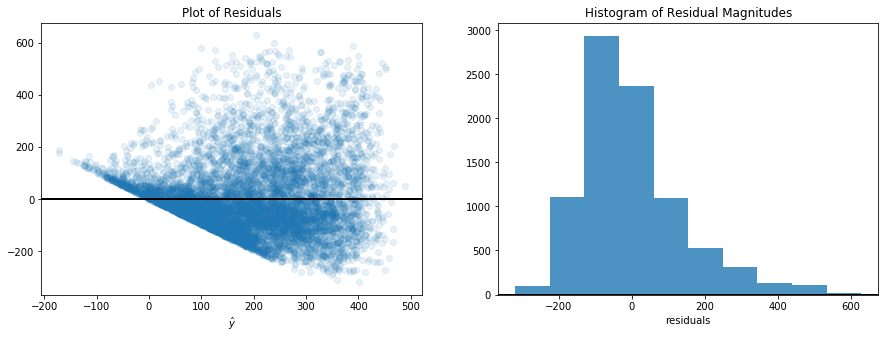

In [33]:
# your code here
residuals = y_train[:,0] - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

**FINDINGS:**

By plotting the residuals of our model as we have above in figure 1 and figure 2, the plots reveal concerning trends related to the basic OLS assumptions of linearity, constant variance, and normality.

- In figure 1 we can see an imperfect **linear relationship** between the predicted values $\hat{y}$ and their residuals, with its sharp downward angle along the lower edge of the plotted residuals, something that makes sense given the non-negative nature of the observed values $y$ against which we are comparing $\hat{y}$ (which the model does not restrict to non-negative values) to calculate our residuals.
- In figure 1 we can also see that as the predicted value $\hat{y}$ increases, the model exhibits some increasing spread in the residuals, meaning that there is heteroscedasticity present and that there is not **constant variance** in the residuals.
- And, lastly, in figure 2, when plotting a histogram of the residuals, we can see that the residuals exhibit a notable right skew towards the larger positive residuals, and the mode of the distribution is negative (i.e. below the zero residual line), leading to concerns related to the **normality** of our errors.

**Taking these three violations of our basic OLS assumptions into account, I would say that the OLS model may not be the best suited model for predicting our variable of interest given these predictors.**

**3.5 Perhaps we can do better via a model...**

In [34]:
# your code here
X_train_poly = X_train.copy()
X_train_poly['hour2'] = X_train_poly.hour**2
X_train_poly['temp2'] = X_train_poly.temp**2
X_train_poly['hum2'] = X_train_poly.hum**2


X_test_poly = X_test.copy()
X_test_poly['hour2'] = X_test_poly.hour**2
X_test_poly['temp2'] = X_test_poly.temp**2
X_test_poly['hum2'] = X_test_poly.hum**2

poly_model = OLS(y_train, X_train_poly).fit()
print(r2_score(y_test, poly_model.predict(X_test_poly)))
poly_model.summary()

0.49059037908107184


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        10:59:52   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -193.3332     17.588    -10.992      0.000    -227.810    -158.857
hour          40.2211      0.840     47.896      0.000      38.575      41.867
holiday      -14.0310      7.656     -1.833      0.067     -29.039       0.977
year          83.2098      2.781     29.921      0.000      77.758      88.661
workingday    13.2241      3.212      4.117      0.000       6.928      19.520
temp          46.0096     78.769      0.584      0.559    -108.397     200.416
atemp        148.5309     61.182      2.428      0.015      28.599     268.463
hum           42.3171     45.426      0.932      0.352     -46.729     131.363
windspeed    -19.4101     12.531     -1.549      0.121     -43.973       5.153
spring        46.8322      8.714      5.374      0.000      29.750      63.914
summer        25.4085     10.202      2.490      0.013       5.410      45.407
fall          74.7289      8.643      8.646      0.000      57.787      91.671
Feb           -2.2754      7.037     -0.323      0.746     -16.070      11.519
Mar            9.1429      7.906      1.156      0.248      -6.355      24.641
Apr          -12.2792     11.781     -1.042      0.297     -35.373      10.814
May          -15.6791     12.489     -1.255      0.209     -40.160       8.802
Jun          -29.8762     12.639     -2.364      0.018     -54.652      -5.100
Jul          -51.5208     14.156     -3.640      0.000     -79.269     -23.773
Aug          -23.3642     13.901     -1.681      0.093     -50.613       3.884
Sept          11.0442     12.519      0.882      0.378     -13.495      35.584
Oct           -1.9320     11.682     -0.165      0.869     -24.831      20.967
Nov          -27.7996     11.221     -2.478      0.013     -49.795      -5.804
Dec          -19.1169      8.871     -2.155      0.031     -36.506      -1.728
Mon           -0.9673      3.434     -0.282      0.778      -7.699       5.764
Tue            0.9441      3.753      0.252      0.801      -6.412       8.301
Wed           -1.8581      3.731     -0.498      0.619      -9.172       5.456
Thu           -2.7283      3.669     -0.744      0.457      -9.921       4.465
Fri            3.8028      3.671      1.036      0.300      -3.393      10.999
Sat           18.1315      5.113      3.546      0.000       8.109      28.154
Cloudy        -9.5074      3.389     -2.805      0.005     -16.151      -2.864
Snow         -46.9213      5.765     -8.139      0.000     -58.222     -35.620
Storm         34.1383     90.378      0.378      0.706    -143.024     211.301
hour2         -1.3881      0.034    -40.654      0.000      -1.455      -1.321
temp2        140.6804     46.276      3.040      0.002      49.968     231.393
hum2        -126.8873     36.621     -3.465      0.001    -198.673     -55.102
==============================================================================
Om

(0, 23)
(0.02, 0.98)
(0.0, 1.0)


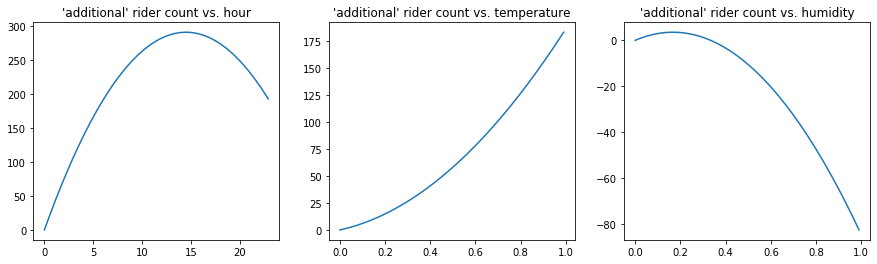

In [35]:
hour_coef = poly_model.params[['hour','hour2']]
temp_coef = poly_model.params[['temp','temp2']]
hum_coef = poly_model.params[['hum','hum2']]

# just a sanity check.  hour should be between 0 and 23, and temp and hum should 
# be between 0 and 1 (they are normalized).  This is needed for graphing the relationships
print((np.min(X_train['hour']),np.max(X_train['hour'])))
print((np.min(X_train['temp']),np.max(X_train['temp'])))
print((np.min(X_train['hum']),np.max(X_train['hum'])))

x_hour = np.arange(0,23,0.1)
x_temp = x_hum = np.arange(0,1,0.01)

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].plot(x_hour,hour_coef[0]*x_hour+hour_coef[1]*(x_hour**2))
axs[0].set_title("'additional' rider count vs. hour")
axs[1].plot(x_temp,temp_coef[0]*x_temp+temp_coef[1]*(x_temp**2))
axs[1].set_title("'additional' rider count vs. temperature")
axs[2].plot(x_hum,hum_coef[0]*x_hum+hum_coef[1]*(x_hum**2))
axs[2].set_title("'additional' rider count vs. humidity");

**FINDINGS:**

Before interpreting these polynomial terms, I'd like to first note **Warning 2** printed above, which indicates a "strong multicollinearity problem" in our model. Given our prior findings from the scatter matrix in question 2.6., particularly related to the extremely strong correlation between the predictors `temp` and `atemp`, **I am going to be hesitant in lending much credence to the model's estimated coefficients for `temp` and `temp^2`, while `atemp` is still included as a predictor in our model.**

That being said, **the model has found each of our newly added polynomial terms to be statistically significant** at a significance level of 5% (as summarized in the table above, showing `temp^2`, `hour^2`, and `hum^2` p-values all to be smaller than 0.05).

As for the predictors used to generate these polynomial terms, **`temp` and `hum` are no longer found to be significant** (while `temp`'s closely correlated `atemp` is still significant).

**Interpreting these 4 still significant polynomial-related coefficients**, the model estimates (holding all other predictors constant):

- a  **140.68  count increase** in bike rentals for each **squared-degree-celsius** increase in temperature
- a  **40.22  count increase** in bike rentals for each **one-hour** increase in time of day
- a  **-1.39  count decrease** in bike rentals for each **squared-hour** increase in time of day
- a  **-126.89  count decrease** in bike rentals for each **squared-percent** increase in relative humidity

Overall, by adding these degree-2 polynomial predictors to our model, we have improved our model's $R^2$ score, meaning that the new polynomial model ($R^2=0.5085$) accounts for more of the variability in rental counts given our predictors than did the model without polynomial terms ($R^2=0.4116$).

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [36]:
# your code here
X_train_drop = X_train.drop(['workingday','atemp','spring','summer','fall'], axis=1)
OLS(y_train, X_train_drop).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        10:59:53   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.015     -47.322      -5.089
hour           7.2218      0.234     30.871      0.000       6.763       7.680
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
year          77.9687      3.035     25.691      0.000      72.020      83.918
temp         425.3856     16.922     25.137      0.000     392.214     458.557
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
windspeed      3.0647     13.166      0.233      0.816     -22.743      28.872
Feb          -10.3801      7.624     -1.362      0.173     -25.324       4.564
Mar            4.8473      7.834      0.619      0.536     -10.510      20.205
Apr            5.6103      8.422      0.666      0.505     -10.899      22.119
May           -2.4330      9.725     -0.250      0.802     -21.497      16.631
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Sept          15.9133     10.059      1.582      0.114      -3.805      35.632
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Mon            9.6638      5.802      1.666      0.096      -1.709      21.036
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
Wed            8.5964      5.676      1.515      0.130      -2.529      19.722
Thu            5.9261      5.641      1.050      0.294      -5.132      16.984
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Cloudy         7.0689      3.692      1.915      0.056      -0.169      14.306
Snow         -27.3958      6.112     -4.483      0.000     -39.376     -15.415
Storm         44.8939     99.348      0.452      0.651    -149.852     239.640
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**FINDINGS:**

After dropping the predictors `workingday`, `atemp`, `spring`, `summer`, and `fall` to minimize multicollinearity in our model, the estimated coefficients for the associated predictors that remain, and were most likely collinear with those that were removed, are far more sensible. For instance, prior to removing `atemp` (in our results to question 3.2), both `temp` and `atemp` were showing much smaller coefficients individually and their 95% confidence intervals were remarkable wide for a type of predictor that I would expect to have a clear and strong positive relationship to bike rental behavior. Now, after removing `temp`, the coefficient is much larger and the interval much narrower, meaning that the model is more certain about the estimate. Likewise, after removing the seasonal predictors `spring`, `summer`, and `fall`, the monthly predictors exhibit a sinusoidal pattern around zero, undulating from strongly negative to strongly positive throughout the year, as I would expect. This is far more sensible than the question 3.2 model, where all monthly predictors were negative as a result of their multicollinearity with the seasonal predictors.

One of the most accessible and most concise statements I've read about multicollinearity and the problem it presents for regression coefficients was contained in an online article shared by our cs109a TA, Yajaira Gonzalez, on the Ed forum. In that article, Jim Frost states that "the interpretation of a regression coefficient is that it represents the mean change in the dependent variable for each 1 unit change in an independent variable when you hold all of the other independent variables constant." \[Source 3\] Basically, this means that multicollinearity can lead to erroneous coeffecient values between collinear predictors because those predictors are no longer truly independent. Therefore, the coeffecients' interpretive logic breaks down and by making a 1 unit change in one collinear predictor, you are including other related predictors in those that you attempt to simultaneously hold constant. This results in a model that begins to have difficulty separating the effect of one predictor from that of another because they move together. This is a problem exasperated by extremely collinear predictors. For example, by relating the exceptional strength of the collinear relationship we saw between `temp` and `atemp` back in the `scatter_matrix` of question 2.6 with the logic of this statement about multicollinearity and modelling challenges of related coefficients, it makes perfect sense that the model in question 3.2 would have such difficulty estimating a precise coefficient for both the `temp` and `atemp` variable together, as evidenced by their surprisingly wide 95% confidence intervals in that first model.

sources:

3. Frost, Jim. "Multicollinearity in Regression Analysis: Problems, Detection, and Solutions" Statistics by Jim, https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [37]:
BSS_train = BSS_train.drop(['workingday', 'atemp'], axis=1)
BSS_test = BSS_test.drop(['workingday', 'atemp'], axis=1)

**4.2 Write a function to standardize...**

As per Brandon Walker on the HW3 Errata posted on Ed:

> Question 4.2: Ignore the  "including the polynomial columns."  At this point, we don't have any polynomial columns.

In [38]:
# your code here

binary_columns = ['holiday','Feb', 'Mar', 'Apr',
                  'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 
                  'Dec', 'spring', 'summer', 'fall', 'Mon', 'Tue', 
                  'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']

def scale_datasets(train_data, test_data, cols_to_scale):
    """
    This function will be used to standardize columns in your datasets. It
    also allows you to pass in a test dataset, which will be standardized
    using the stats from the training data. 
    
    :param: train: The training dataset
    :param: test: The test dataset, which will be standardized using stats 
                  from the training data. 
    :param: cols_to_scale: List containing the column names to be standardized
    :return: (DataFrame, DataFrame) Standardized test and training DataFrames
    """
    
    train = train_data.copy()
    test = test_data.copy()
    
    # Fit the scaler on the training data
    scaler = StandardScaler().fit(train[cols_to_scale])

    # Scale both the test and training data. 
    train[cols_to_scale] = scaler.transform(train[cols_to_scale])
    test[cols_to_scale] = scaler.transform(test[cols_to_scale])
    
    return train, test

In [39]:
def split_columns(df, target_col, drop_columns):
    """
    :param: df: Your DataFrame
    :param: target_col: The name of the response variable
    :param: drop_columns: List containing the column names you want to drop
    :return: (X_train, y_train)
    """
    # Get the response variable
    y_train = df[[target_col]]

    # Drop the required columns
    X_train = df.drop(drop_columns,axis=1)
    
    return X_train, y_train

target_column = 'counts'

drop_columns = ['counts']

practice_X_train, practice_y_train = split_columns(BSS_train, 
                                                   target_column, 
                                                   drop_columns)

print(practice_X_train.columns.values)
practice_X_train.head()
print(type(practice_X_train))

['hour' 'holiday' 'year' 'temp' 'hum' 'windspeed' 'spring' 'summer' 'fall'
 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'Mon'
 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm']
<class 'pandas.core.frame.DataFrame'>


In [40]:
# Get the columns that we actually want to scale
to_scale = practice_X_train.columns.difference(binary_columns)

practice_X_train_scaled, _ = scale_datasets(practice_X_train, 
                                            practice_X_train, 
                                            to_scale)

practice_X_train_scaled.describe()

,hour,holiday,year,temp,hum,windspeed,spring,summer,fall,Feb,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,6.225120e-17,0.029347,-7.318860e-17,-2.330587e-17,-4.996451e-16,2.563645e-16,0.250316,0.259293,0.243641,0.077224,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,1.000058e+00,0.168788,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.433220,0.438272,0.429303,0.266962,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,-1.666359e+00,0.000000,-1.006813e+00,-2.474192e+00,-3.251974e+00,-1.546636e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.042663e-01,0.000000,-1.006813e+00,-8.122824e-01,-7.554808e-01,-6.987336e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782674e-02,0.000000,9.932327e-01,1.867233e-02,-2.733697e-02,2.746035e-02,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.199197e-01,0.000000,9.932327e-01,8.496271e-01,8.048274e-01,5.118601e-01,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.638331e+00,1.000000,9.932327e-01,2.511537e+00,1.949053e+00,5.355858e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.3 Write code to augment your a dataset with higher-order features for...**

In [41]:
# your code here

def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    # Make a copy of the dataset
    poly_dataset = dataset.copy()
    
    # Use this to generate the polynomial terms
    maker = PolynomialFeatures(degree, include_bias=False)
        
    # Loop over each column we want to generate polynomials terms for
    for cur_col in columns:
        # Create the polynomial terms
        poly_values = maker.fit_transform(poly_dataset[[cur_col]])
        
        # Get the new column names
        poly_names = maker.get_feature_names([cur_col])
        
        # Add the new columns back to the original dataframe copy
        to_add = pd.DataFrame(poly_values[:,1:], 
                              index=poly_dataset.index, 
                              columns=poly_names[1:])
        
        poly_dataset = pd.concat([poly_dataset, to_add], axis=1)

    return poly_dataset

poly_columns = ['temp', 'hum','windspeed', 'hour']

practice_X_train_poly = add_poly_features(practice_X_train_scaled,3, poly_columns)

print(practice_X_train_poly.columns.values)
practice_X_train_poly.head()

['hour' 'holiday' 'year' 'temp' 'hum' 'windspeed' 'spring' 'summer' 'fall'
 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'Mon'
 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm' 'temp^2' 'temp^3'
 'hum^2' 'hum^3' 'windspeed^2' 'windspeed^3' 'hour^2' 'hour^3']


,hour,holiday,year,temp,hum,windspeed,spring,summer,fall,Feb,...,Snow,Storm,temp^2,temp^3,hum^2,hum^3,windspeed^2,windspeed^3,hour^2,hour^3
0,1.350966,0,0.993233,-1.331629,-0.131358,0.511860,0,0,0,0,...,0,0,1.773236,-2.361293,0.017255,-0.002267,0.262001,0.134108,1.825110,2.465662
1,0.776238,0,-1.006813,0.641888,1.064879,0.511860,0,0,1,0,...,1,0,0.412021,0.264471,1.133967,1.207537,0.262001,0.134108,0.602545,0.467718
2,-0.373220,0,0.993233,1.368974,0.180704,-0.214334,0,1,0,0,...,0,0,1.874089,2.565579,0.032654,0.005901,0.045939,-0.009846,0.139293,-0.051987
3,0.776238,0,0.993233,0.641888,-2.107748,0.875363,1,0,0,0,...,0,0,0.412021,0.264471,4.442601,-9.363882,0.766260,0.670755,0.602545,0.467718
4,-0.516902,0,0.993233,-1.643237,-1.171563,-0.456939,0,0,0,0,...,0,0,2.700228,-4.437116,1.372560,-1.608040,0.208794,-0.095406,0.267188,-0.138110


**4.4 Write code to add interaction terms to the model...**

In [42]:
# your code here

interact_left = ['temp','hum','windspeed']
interact_right = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept',
                  'Oct', 'Nov', 'Dec','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

def build_interaction(df, interact_left, interact_right):
    """
    :param df: Your data
    :param interact_left: The first set of columns you want to use in interactions
    :param interact_right: The set of columns you want to generate interactions terms
                           with in interact_left
    """
    result_df =  df.copy()
    
    # Loop over all the left interactions
    for left_name in interact_left:
        left_column = df[left_name]
        
        # For each left interaction column, create an interaction
        # with each column in the right interaction list.
        for right_name in interact_right:
            right_column = df[right_name]
            combined_name = "{}*{}".format(left_name, right_name)
            result_df[combined_name] = left_column*right_column

    return result_df


practice_train_done = build_interaction(practice_X_train_poly, 
                                        interact_left, interact_right)

print(practice_train_done.columns.values)
#display(HTML(practice_train_done.to_html())) 
practice_train_done.head()

['hour' 'holiday' 'year' 'temp' 'hum' 'windspeed' 'spring' 'summer' 'fall'
 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'Mon'
 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm' 'temp^2' 'temp^3'
 'hum^2' 'hum^3' 'windspeed^2' 'windspeed^3' 'hour^2' 'hour^3' 'temp*Feb'
 'temp*Mar' 'temp*Apr' 'temp*May' 'temp*Jun' 'temp*Jul' 'temp*Aug'
 'temp*Sept' 'temp*Oct' 'temp*Nov' 'temp*Dec' 'temp*Mon' 'temp*Tue'
 'temp*Wed' 'temp*Thu' 'temp*Fri' 'temp*Sat' 'hum*Feb' 'hum*Mar' 'hum*Apr'
 'hum*May' 'hum*Jun' 'hum*Jul' 'hum*Aug' 'hum*Sept' 'hum*Oct' 'hum*Nov'
 'hum*Dec' 'hum*Mon' 'hum*Tue' 'hum*Wed' 'hum*Thu' 'hum*Fri' 'hum*Sat'
 'windspeed*Feb' 'windspeed*Mar' 'windspeed*Apr' 'windspeed*May'
 'windspeed*Jun' 'windspeed*Jul' 'windspeed*Aug' 'windspeed*Sept'
 'windspeed*Oct' 'windspeed*Nov' 'windspeed*Dec' 'windspeed*Mon'
 'windspeed*Tue' 'windspeed*Wed' 'windspeed*Thu' 'windspeed*Fri'
 'windspeed*Sat']


,hour,holiday,year,temp,hum,windspeed,spring,summer,fall,Feb,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
0,1.350966,0,0.993233,-1.331629,-0.131358,0.511860,0,0,0,0,...,0.0,0.00000,0.0,0.51186,0.0,0.0,0.0,0.511860,0.0,0.0
1,0.776238,0,-1.006813,0.641888,1.064879,0.511860,0,0,1,0,...,0.0,0.51186,0.0,0.00000,0.0,0.0,0.0,0.511860,0.0,0.0
2,-0.373220,0,0.993233,1.368974,0.180704,-0.214334,0,1,0,0,...,-0.0,-0.00000,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.214334,-0.0,-0.0
3,0.776238,0,0.993233,0.641888,-2.107748,0.875363,1,0,0,0,...,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
4,-0.516902,0,0.993233,-1.643237,-1.171563,-0.456939,0,0,0,0,...,-0.0,-0.00000,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0


**4.5 Combine all your code so far into a function named...**

In [43]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    # add code here 
    return x_train,y_train, x_val,y_val


In [44]:
# your code here
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    # Split and drop what we don't need
    x_train, y_train = split_columns(train_df, 
                                     target_col, 
                                     drop_columns=bad_columns)
    x_val, y_val = split_columns(val_df, 
                                 target_col, 
                                 drop_columns=bad_columns)
    
    # Scale the Columns
    to_scale = x_train.columns.difference(binary_columns)
    x_train, x_val = scale_datasets(x_train, x_val, to_scale)

    # Add Polynomial Features
    x_train = add_poly_features(x_train,  degree, columns=columns_forpoly)
    x_val = add_poly_features(x_val, degree, columns=columns_forpoly)

    # Add the Interaction Terms
    x_train = build_interaction(x_train, interact_left, interact_right)
    x_val = build_interaction(x_val, interact_left, interact_right)
    
    return x_train,y_train, x_val,y_val

X_train, y_train, X_val, y_val = get_design_mats(BSS_train, BSS_test, degree=3)

X_train.describe()

,hour,holiday,year,temp,hum,windspeed,spring,summer,fall,Feb,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,6.225120e-17,0.029347,-7.318860e-17,-2.330587e-17,-4.996451e-16,2.563645e-16,0.250316,0.259293,0.243641,0.077224,...,-0.018335,-0.013421,-0.004617,-0.007544,-0.001365,0.004270,-0.003622,0.001751,-0.002836,0.005889
std,1.000058e+00,0.168788,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.433220,0.438272,0.429303,0.266962,...,0.266054,0.301277,0.287834,0.302356,0.386093,0.371303,0.380922,0.363139,0.391186,0.384264
min,-1.666359e+00,0.000000,-1.006813e+00,-2.474192e+00,-3.251974e+00,-1.546636e+00,0.000000,0.000000,0.000000,0.000000,...,-1.546636,-1.546636,-1.546636,-1.546636,-1.546636,-1.546636,-1.546636,-1.546636,-1.546636,-1.546636
25%,-8.042663e-01,0.000000,-1.006813e+00,-8.122824e-01,-7.554808e-01,-6.987336e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782674e-02,0.000000,9.932327e-01,1.867233e-02,-2.733697e-02,2.746035e-02,0.000000,0.000000,0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
75%,9.199197e-01,0.000000,9.932327e-01,8.496271e-01,8.048274e-01,5.118601e-01,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.638331e+00,1.000000,9.932327e-01,2.511537e+00,1.949053e+00,5.355858e+00,1.000000,1.000000,1.000000,1.000000,...,3.660864,3.176465,3.418259,3.781761,4.266161,4.750561,3.660864,3.660864,4.993166,5.234961


**4.6 For each degree in 1 through 8...**

In [45]:
# your code here

degrees = range(1,9)
train_r2 = np.zeros(len(degrees))
test_r2 = np.zeros(len(degrees))

for cur_degree in degrees:

    X_train, y_train, X_test, y_test = get_design_mats(BSS_train, 
                                                       BSS_test,  
                                                       cur_degree)

    fitted_model = LinearRegression().fit(X_train, y_train)

    train_r2[cur_degree-1] = fitted_model.score(X_train, y_train)
    test_r2[cur_degree-1] = fitted_model.score(X_test, y_test)

pd.DataFrame({'train_score': train_r2, 'test_score': test_r2},
             index=degrees)

,train_score,test_score
1,0.442491,0.432133
2,0.531034,0.514651
3,0.574562,0.563566
4,0.576406,0.566718
5,0.591166,0.578422
6,0.613726,0.601465
7,0.652289,0.636699
8,0.661595,0.646464


**4.7 Discuss patterns you see in the results...**

**RECOMMENDATION:**

Given the model results highlighted in question 4.6, **it would appear that the TEST $R^2$ score increases with each successive degree polynomial added to our predictors,** with the notable difference of $R^2=0.3972$ for the degree-1 model and $R^2=0.6253$ for the degree-8 model, and slight plateaus in our $R^2$ gains at degree-3 and degree-7.

Something surprising is just how little our $R^2$ score decreases between the train and TEST sets at each degree-level. **This would suggest that, even at degree-8 we are not yet overfitting to the training data.**

Futhermore, as can be seen in the plots 1.a and 1.b above, the spread of our residuals decrease with each successive degree polynomial, slightly reducing the heteroscedasticity (or improving the constant variance) and decreasing the skew (or improving the normality) of our residuals. This improvement is most notable in our degree-8 polynomial model as detailed in figures 2.a and 2.b. While linearity is still a concern given the same imperfect linear relationship I discussed back in question 3.4, **both constant variance and normality are exhibiting some improvement with the addition of polynomial features.**

**As for my recommendation, given that $R^2$ is at its greatest for the degree-8 model, there is not yet any indication of overfitting, and that model shows the most marked improvement in our constant variance and normality assumptions, I would select the degree-8 model, given each of the choices presented.**

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [46]:
bikes_train, bikes_val = train_test_split(BSS_train, test_size=.2)

In [47]:
# your code here

alphas = np.array([.01, .05, .1, .5, 1, 5, 10, 50, 100])

# Arrays to hold our scores
train_r2s = np.zeros((len(degrees),len(alphas)))
val_r2s = np.zeros((len(degrees),len(alphas)))

# Loop over each degree
for cur_row, cur_degree in enumerate(degrees):

    # Get the  design matrix
    X_train, y_train, X_test, y_test = get_design_mats(bikes_train, 
                                                         bikes_val, 
                                                         cur_degree)

    # Loop over each alpha value
    for cur_col, cur_alpha in enumerate(alphas):

        # Fit and Score
        fitted_model = Ridge(alpha=cur_alpha).fit(X_train, y_train)
        
        # Get predictions on the test set
        y_test_hat = fitted_model.predict(X_test)

        # Store results
        train_r2s[cur_row,cur_col] = fitted_model.score(X_train, y_train)
        val_r2s[cur_row,cur_col] = r2_score(y_test, y_test_hat)
                    
print("Training Set Performance")
display(pd.DataFrame(train_r2s, index = degrees, columns = alphas))

print("Validation Set Performance")
pd.DataFrame(val_r2s, index = degrees, columns = alphas)

Training Set Performance


,0.01,0.05,0.10,0.50,1.00,5.00,10.00,50.00,100.00
1,0.446157,0.446157,0.446157,0.446149,0.446132,0.445934,0.445673,0.443453,0.440888
2,0.532939,0.532939,0.532939,0.532930,0.532915,0.532749,0.532514,0.530520,0.528223
3,0.576553,0.576553,0.576553,0.576548,0.576537,0.576426,0.576247,0.573954,0.570394
4,0.579055,0.579055,0.579055,0.579051,0.579044,0.578945,0.578765,0.576421,0.572798
5,0.593652,0.593652,0.593651,0.593644,0.593630,0.593485,0.593282,0.591217,0.588385
6,0.615763,0.615763,0.615762,0.615752,0.615733,0.615429,0.614791,0.608130,0.601777
7,0.654577,0.654576,0.654574,0.654518,0.654360,0.651289,0.646289,0.621895,0.608955
8,0.663093,0.663090,0.663083,0.662888,0.662388,0.655638,0.647776,0.621289,0.610275


Validation Set Performance


,0.01,0.05,0.10,0.50,1.00,5.00,10.00,50.00,100.00
1,0.418689,0.418710,0.418736,0.418913,0.419092,0.419982,0.420673,0.422954,0.423943
2,0.515596,0.515630,0.515669,0.515894,0.516069,0.516697,0.517107,0.518179,0.518388
3,0.558914,0.558933,0.558955,0.559095,0.559219,0.559775,0.560188,0.560839,0.559732
4,0.557399,0.557418,0.557441,0.557585,0.557714,0.558291,0.558712,0.559322,0.558146
5,0.572977,0.573003,0.573033,0.573209,0.573350,0.573882,0.574245,0.574894,0.574207
6,0.597332,0.597387,0.597449,0.597804,0.598072,0.598870,0.599059,0.595652,0.591412
7,0.635555,0.635587,0.635625,0.635849,0.635986,0.634421,0.630425,0.608945,0.598024
8,0.648404,0.648391,0.648371,0.648082,0.647486,0.640435,0.632607,0.607734,0.598798


**5.2 Find the best-scoring degree and regularization combination.**

In [48]:
# your code here

# Find out best test score
best_score = np.max(val_r2s)
best_degree_ind = np.argmax(np.max(val_r2s, axis=1))
best_alpha_ind = np.argmax(np.max(val_r2s, axis=0))
best_degree = degrees[best_degree_ind]
best_alpha = alphas[best_alpha_ind]

print("The best model has degree {} and Lambda={}.".format(best_degree, 
                                                           best_alpha))
                                                                      
print("The best model has R2={}".format(val_r2s[best_degree_ind, best_alpha_ind]))

# Fit our optimal model
x_train, y_train, x_score, y_score = get_design_mats(bikes_train, 
                                                     bikes_val, 
                                                     best_degree)

best_model = Ridge(alpha=best_alpha).fit(x_train,y_train)
best_model

The best model has degree 8 and Lambda=0.01.
The best model has R2=0.6484037018463638


Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

**5.3 It's time to see how well our selected model...**


In [49]:
# your code here
X_train, y_train, X_test, y_test = get_design_mats(BSS_train, 
                                                   BSS_test, 
                                                   best_degree)

r2_test = best_model.score(X_test, y_test)
r2_test

0.6441845141181908

**INTERPRETATION:**

Our model performs slightly worse on the test dataset, with a slightly lower TEST $R^2$ score of 0.6442 vs. a validation $R^2$ of 0.6484.

This could be attributed to two main reasons. First, the validation dataset was split along with our training dataset from our original training set, which could lead to similar distributions between our two datasets. The R^2 score for the model could then be more accurate for the validation set since it was trained on a slightly similar dataset, while the test dataset is entirely new and has the model separately run on. The second and more likely reason is that our model is first trained on the training dataset and then further optimized and adjusted based on the validation dataset, which means that the validation dataset is actually part of the process to creating the model, and our model has been adjusted to maximize fit with the validation dataset, while the test dataset is an entirely separate application/prediction of the model. Thus, we would expect our R^2 score from the test dataset to be lower than that for the validation dataset.


**5.4 Build a dataset with polynomial degree 1...**

In [50]:
#your code here
X_train, y_train, X_test, y_test = get_design_mats(BSS_train, BSS_test, 1)

fitted_OLS = LinearRegression().fit(X_train, y_train)

alphas = (.1,.5,1,5,10,50,100)

fitted_ridge = RidgeCV(alphas=alphas).fit(X_train, y_train)
fitted_lasso = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, np.ravel(y_train))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


**5.5 Plot histograms of the coefficients found...**

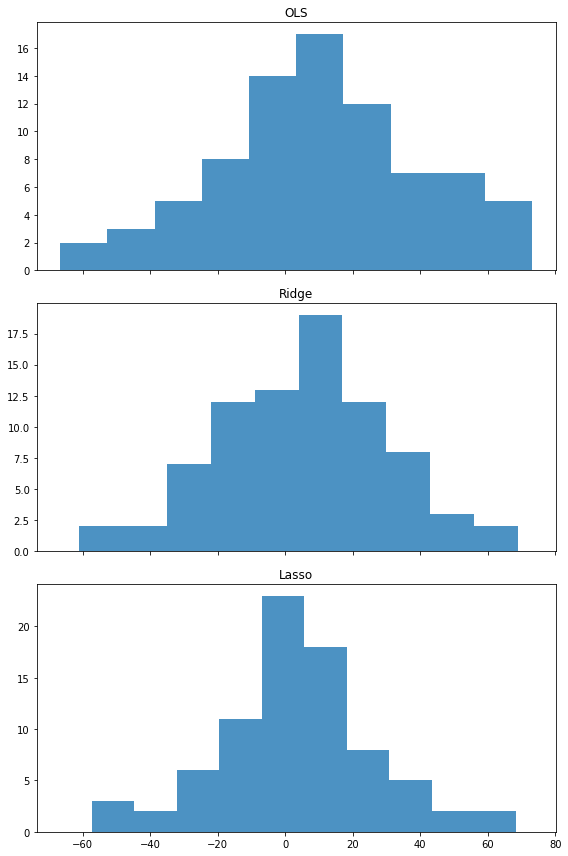

In [51]:
# your code here
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

axs[0].hist(fitted_OLS.coef_[0], alpha=0.8)
axs[0].set_title("OLS")

axs[1].hist(fitted_ridge.coef_[0], alpha=0.8)
axs[1].set_title("Ridge")

axs[2].hist(fitted_lasso.coef_, alpha=0.8)
axs[2].set_title("Lasso")
plt.tight_layout()

**FINDINGS:**

Based on the histograms shown above, it is a bit difficult to discern trends in the magnitude of the coefficients for each model. However, if I examine the height of each histogram bin carefully, I can see a slight redistribution of coeffiecients closer to the zero-value for both Ridge and Lasso, and I can see a noteable jump in the zero-centered bin in the Lasso model, indicating that more coefficients have been shrinked to, or at least very close to, zero.

**5.6 The plots above show the overall distribution of...**

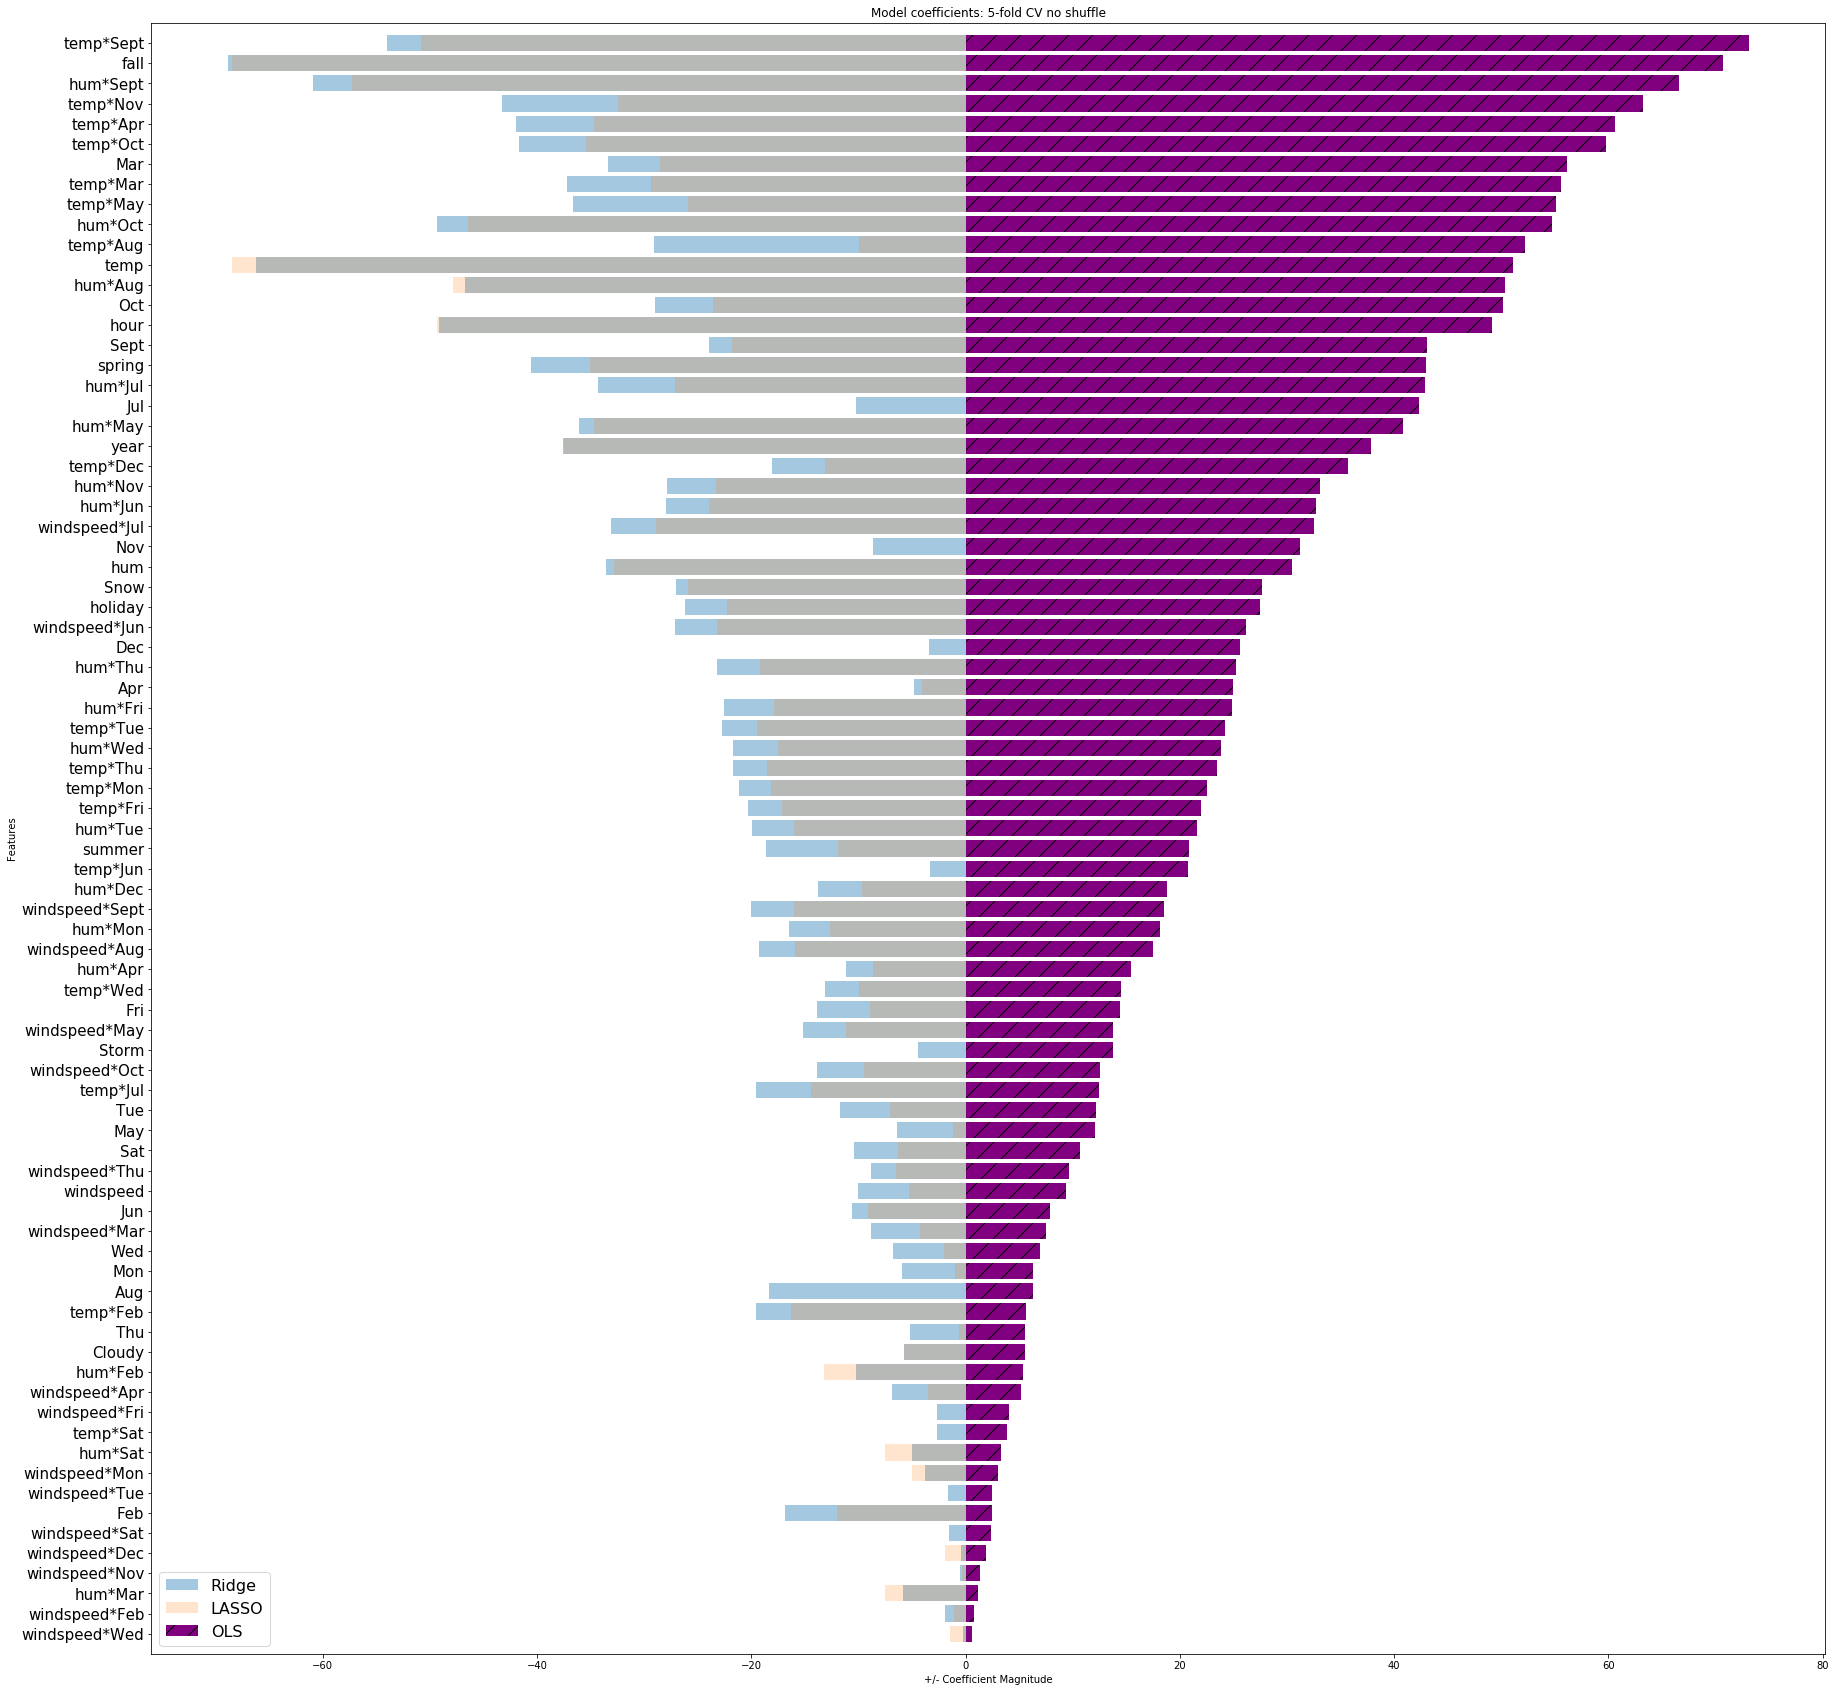

In [52]:
# your code here
feature_names = X_train.columns.values

Ridge_coefficients = fitted_ridge.coef_
Lasso_coefficients = fitted_lasso.coef_
OLS_coefficients = fitted_OLS.coef_

si= np.argsort(np.abs(fitted_OLS.coef_))
feature_names = X_train.columns.values[si][0]
n_coeffs = len(feature_names)

plt.figure(figsize=(30,30))
plt.barh(np.arange(n_coeffs), 
         -np.abs(Ridge_coefficients)[0][si][0], 
         alpha=0.4, label='Ridge')

plt.barh(np.arange(n_coeffs), 
         -np.abs(Lasso_coefficients)[si][0], 
         alpha=0.2, label='LASSO')
plt.barh(np.arange(n_coeffs), 
         np.abs(OLS_coefficients)[0][si][0], 
         color='purple', hatch='/', label='OLS')

plt.yticks(range(n_coeffs), feature_names, rotation=0, fontsize=15)
plt.ylim(-1,n_coeffs)
#plt.xlim(-100,300)

plt.legend(fontsize=16)

plt.title("Model coefficients: 5-fold CV no shuffle")
plt.ylabel("Features")
plt.xlabel("+/- Coefficient Magnitude");

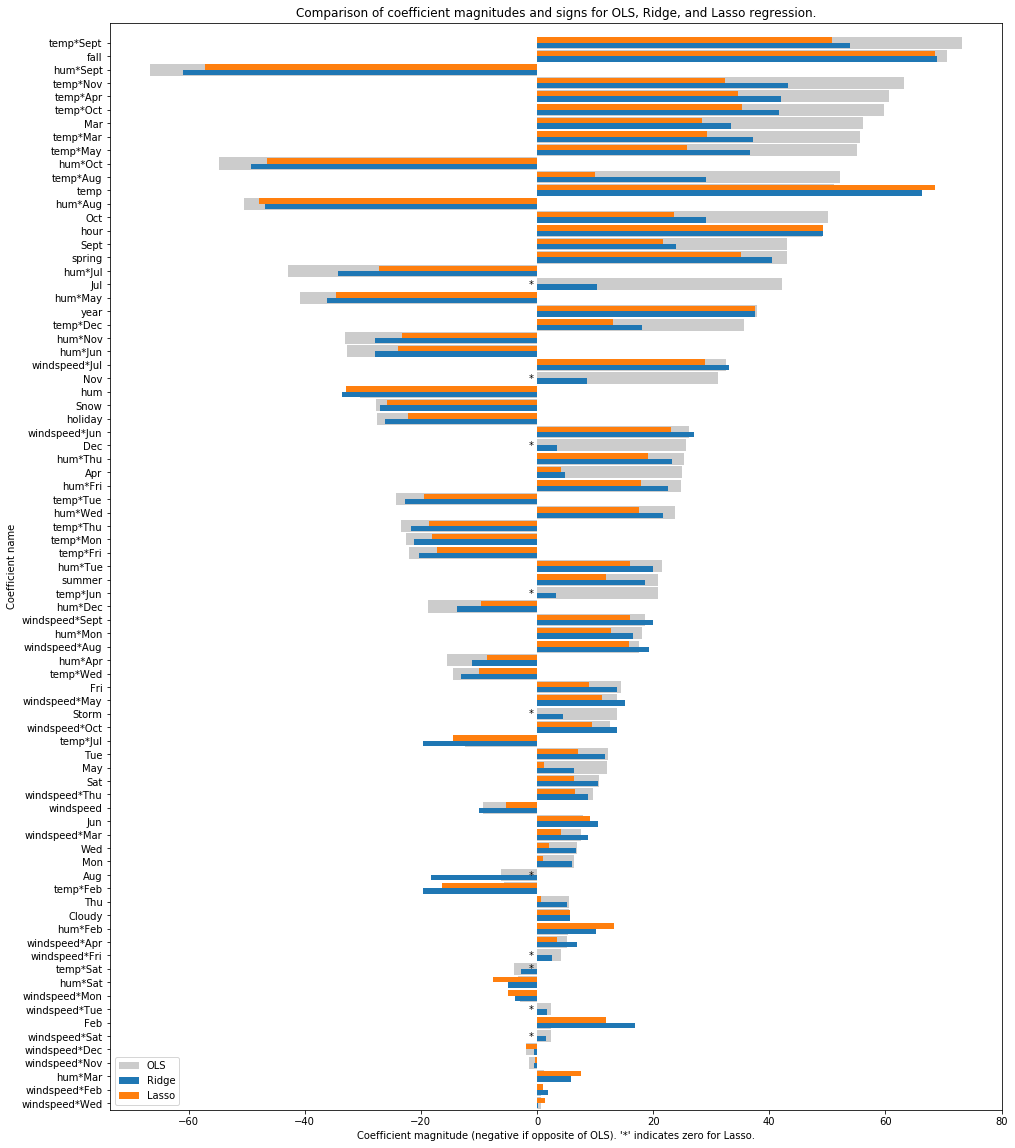

In [53]:
# your code here
feature_names = X_train.columns.values
n_coeffs = len(feature_names)

coef_labels = X_train.columns
coef_ticks = np.arange(len(coef_labels))
label_order = np.argsort(np.abs(fitted_OLS.coef_))

fig, ax = plt.subplots(1, 1, figsize=(16, 20))
signs = np.sign(fitted_OLS.coef_[0][label_order])

ax.barh(coef_ticks, (signs * np.abs(fitted_OLS.coef_)[0][label_order])[0] , height=.9, color='#cccccc', label='OLS')
ax.barh(coef_ticks-.2, (signs * np.abs(fitted_ridge.coef_)[0][label_order])[0], alpha=1, height=.4, label='Ridge')
ax.barh(coef_ticks+.2, (signs * np.abs(fitted_lasso.coef_)[label_order])[0], alpha=1, height=.4, label="Lasso")

plt.yticks(coef_ticks, coef_labels[label_order][0], rotation=0, fontsize=10) ; 
plt.ylim([-.5, len(coef_labels) + .5])

# Mark Lasso zeros
for y, idx in enumerate(label_order[0]):
    if np.abs(fitted_lasso.coef_[idx]) < 1e-3:
        plt.text(-.5, y, '*', verticalalignment='center', horizontalalignment='right')
plt.legend(loc='best');
plt.xlabel("Coefficient magnitude (negative if opposite of OLS). '*' indicates zero for Lasso.")
plt.ylabel("Coefficient name")
plt.title("Comparison of coefficient magnitudes and signs for OLS, Ridge, and Lasso regression.");


**5.7 What trends do you see...**

What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

As per Rashmi Banthia on the HW3 Errata posted on Ed, we are to ignore this question:

> 5.7 You may ignore this  part - "How do the three approaches handle the correlated pair temp and atemp ?".   

**FINDINGS:**

In the plots above, we can see that on average the Ridge and Lasso models shrank the coefficients when compared to those estimated by OLS (see figure 2). In general, the coefficient shrinkage exhibited by Lasso is greater than that exhibited by Ridge, with many coefficients (`Storm`, `Dec`, etc.) shrunk to zero (at least when reported by two decimal points), effectively removing any effects by those predictors from the model. The Ridge and Lasso coefficients for the predictor `Storm` are particularly striking because of the degree to which those estimated coefficients shrunk by 30+ rides for Ridge and by 40+ rides for Lasso. This however makes perfect sense if we refer back to the estimated coefficient and 95% CI plots generated in parts 3.2, 3.5, and 3.6, where the `Storm` 95% CI was very wide and included zero within its bounds. Considering that there are only $n=2$ `Storm` observations in our training dataset, this predictor has very little opportunity to influence the model.

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

This function was useful in my analysis, primarily because of the ease of use and repeatability it provided in generating new and different design matrices simply by modifying function parameters or iterating through lists of parameters to build dictionaries of different design matrices. It was also useful because it allowed us modify / work around / enhance `sklearn`'s default behaviors for the `PolynomialFeatures` and `StandardScaler` methods, and customized them to our needs. If we had cut and pasted the model-building code instead of tying it together in a function, there would have been many more opportunities for errors in our code compared to the `get_design_mats` function in which we only needed to change a parameter or two. As a result, `get_design_mats` would reliably run the exact same processes on our data, changing, in a predictable manner, only the processes affected by our modified parameters. In general, a `get_design_mat` function does seem wise for the benefits outlined above. However, in reality, several different `get_design_mat` functions may need to be built depending on the variety / breadth of feature transformations you may want to experiment with while building, testing, and exploring models. And, in actual process, having a modular set of `get_design_mat` functions or sub-functions, will allow us to perform unit-tests on the function(s), ensuring that we are getting the exact output we expect each and every time, accounting for edge cases as well.

**6.2 What are the costs and benefits of applying ridge/lasso...**

One of the risks associated with forms of regularization for an overfit model ties back to the bias-variance tradeoff, in that, we are minimizing something other than MSE. With both ridge and lasso, we have now introduced a second "regularization" term, meant to penalize large values of $\beta$, which can be represented in the general form:

$$L_{reg}(\beta) \;\;\;\; = \;\;\;\; \underbrace{L(\beta)}_{MSE} \;\;\;\; + \underbrace{\lambda R (\beta)}_{\text{regularization term}}$$

In this also lies the benefit of applying ridge or lasso regularization to an overfit OLS model, in that we have now also introduced a regularization term that penalizes a characteristic of our model that might have led it to be overfit to begin with. In addition, we have introduced a parameter $\lambda$, that allows us to adjust just how severe a penalty is applied to $R(\beta)$ (and by reducing to $\lambda\approx0$, we can recover the MSE). Therefore, through applying regularization, coefficients will typically become smaller. And, in the case of lasso, a subset of coefficients will be forced to zero for less significant predictors. This effectively results in variable selection, "simplifying" our model, which is often beneficial toward lessening overfitting.

Contrasted with other approaches such as setting a specific degree of polynomial or forward selecting polynomial features for a model, variable selection derived via lasso's shrinking of coefficients can help to avoid statistical problems associated with stepwise selection's greedy method for selecting variables. And, as opposed to considering only a subset of variables at once as is done in stepwise selection and the setting of a specific degree of polynomial, lasso evaluates all variables at once and simply minimizes the role in the model of those predictors that are less relevant.

**6.3 This pset posed a purely predictive goal: forecast ridership...**

This really depends on the perspective of those who might ultimately be putting this model and the predictions gained from it to use. For instance, if the predictors used to generate the predictions are truly out of the BikeShare company's control, and they want to predict bike rentals on information they have access to, but can't ultimately affect (such as weather conditions, time of day, day of week, month of year, etc.), a trade-off of predictive accuracy over interpretability may be perfectly acceptable. However, if the BikeShare company had the ability to control some of those inputs, perhaps by making investments in particular marketing efforts, or by investing in new rental kiosks in particular areas of the city, they will most likely want to be able to interpret and quantify what any of their potential actions/investments might yield in terms of new/higher rentals in order to weigh or forecast the cost/benefit trade-off. There is also the issue of diagnosing and understanding unusual predictive behavior under particular set of predictive values. So, even if the model is truly just used to predict rentals using predictors out of their control, having difficult to interpret results will make it increasingly difficult to diagnose and possibly fix strange model behavior and perhaps erode trust in the model. So, extending this thinking to my Ridge and Lasso results in Question 5, if I worked at this company and we were using these specific (out of our control) predictors, I would probably be fine with the level of interpretability provided by either of these models, assuming the model made 'good enough' predictions under the range of conditions we'd expect in D.C. In fact, I would probably find that the coefficients and behavior from these models, while sacrificing some interpretability over basic OLS, were still far easier to understand and the mechanics more accecssible to inquiry than more complex methods such as random forests.

**6.4 Reflect back on our original goal of helping BikeShare predict...**

Based on the our objective (i.e. helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance) and the results of our models above, **I would say that we have not yet accomplished our goal.** There are a several primary reasons why I have come to this conclusion: **(1)** our best $R^2$ score (for our polynomial degree 8 model in question 4.6) has been 0.625, meaning that only 62.5% of the variability in bike rentals are accounted for by this model, meanwhile **(2)** our residuals plots are indicating a questionable adherance to the underlying OLS assumptions of linearity, constant variance, and normality, **(3)** the magnitude of our residuals (i.e. 200 - 400 bike rentals) are quite significant, and **(4)** without location/kiosk-based rental data tied to these predictions, the company will face serious operational risks if they were try to make bike maintentance collection decisions based off of this model, likely causing bike shortages in particular locations.

As for point **(1)** outlined above, perhaps $R^2\approx0.63$ is the best we can do given these predictors. However, if we are seeing the linearity, constant variance, and normality issues referenced in point **(2)**, I am led to believe that a linear model is likely not the best choice for modeling this data (or perhaps the specific predictors we have choosen). I would want to consider more carefully alternate combinations of predictors and definitely predictive methods other than linear regression (which I expect to be better fit for this particular predictive task) before choosing a model for production purposes. As for point **(3)**, a 200-400 rental error in how many bikes might be available for maintenance is quite significant when we consider that at most 800-900 bike rentals might occur during a peak hour during the highest volume days. Bike shortages could cause significant reputational risk to the company and lead to lost future business if disgruntled customers (who rely on these bikes for commuting to and from work) leave or spread negative word-of-mouth. Couple this risk with point **(4)** and there is a serious risk that the company will not have sufficient information to tie rental volume predictions to the specific kiosks from which more or fewer bikes should be taken for daily maintenance, possibly compounding this concern.